### EigenPhi bid value simple anlysis 
Extract all bid csv from the page: https://bidarchive.relayscan.io/ethereum/mainnet/2024-06/index.html


In [4]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
import re

# URL of the page containing the ZIP file links
index_url = "https://bidarchive.relayscan.io/ethereum/mainnet/2024-07/index.html"

# Fetch the content of the page
response = requests.get(index_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract all links that match the pattern
zip_urls = []
counter = 0
for link in soup.find_all('a', href=True):
    if counter > 5:
        break
    href = link['href']
    if re.match(r'\d{4}-\d{2}-\d{2}_all\.csv\.zip$', href):
        zip_urls.append(index_url.rsplit('/', 1)[0] + '/' + href)
        counter += 1


def download_and_extract_csv(zip_url):
    response = requests.get(zip_url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        csv_files = [file for file in thezip.namelist() if file.endswith('.csv')]
        print(f"CSV files found: {csv_files}")  # Print the names of the CSV files
        frames = [pd.read_csv(thezip.open(file)) for file in csv_files]
        return pd.concat(frames, ignore_index=True)


# Combine all data into a single DataFrame
all_data = pd.concat([download_and_extract_csv(url) for url in zip_urls], ignore_index=True)


# Display the DataFrame
print(all_data.shape[0])


CSV files found: ['2024-07-01_all.csv']
CSV files found: ['2024-07-02_all.csv']
CSV files found: ['2024-07-03_all.csv']
CSV files found: ['2024-07-04_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/4173823567.py:32: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-07-05_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/4173823567.py:32: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-07-06_all.csv']
90464644


In [12]:
from data_prep_utils import *
from plot_prep_utils import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_builder = get_builder_info_from_latest_TLDR_talk()
df_eigenphi_builder = df_builder[df_builder['builder_label'] == 'EigenPhi']


In [ ]:

# Filter out the bids of the EigenPhi builders
df_eigenphi_bids = all_data[all_data['builder_pubkey'].isin(df_eigenphi_builder['builder_pubkey'])]

# Convert the 'value' column to numeric
df_eigenphi_bids['value'] = pd.to_numeric(df_eigenphi_bids['value'], errors='coerce')


In [19]:
# 选择 block_number <= 20159999 的行，因为目前data always 只提供到 20159999 as of 2024.06.26
filtered_df_eigenphi_bids = df_eigenphi_bids[df_eigenphi_bids['block_number'] <= 20159999]

# 提取 bid value 最大值 DataFrame, 该 df与slot_t_ms 最大值一致，说明EigenPhi 发出的bid ，都是最新即为最大值
idx_value_max = filtered_df_eigenphi_bids.groupby('block_number')['value'].idxmax()
df_value_max = filtered_df_eigenphi_bids.loc[idx_value_max]

# 检验block number
# print(f"total blocks:" + str(df_value_max['block_number'].nunique()))
# print(f"min block number:" + str(df_value_max['block_number'].min()))
# print(f"max block number:" + str(df_value_max['block_number'].max()))
# print(df_value_max['block_number'].nunique())

# 转换bid value 到eth
df_value_max['value_in_eth'] = df_value_max['value']/10**18

In [21]:
# 读取 Block 范围：20007576 - 20159999 的数据
# we can find that the block data from Data Always missed some blocks, as in
# ethereum__mev__blocks__20010000_to_20019999.parquet
# block_numbers = [
#     20019450, 20019451, 20019453, 20019457, 20019458, 20019459, 20019460, 20019461,
#     20019462, 20019463, 20019465, 20019466, 20019467, 20019468, 20019470, 20019472,
#     20019473, 20019474, 20019476, 20019477, 20019478, 20019479, 20019480, 20019481,
#     20019483, 20019484, 20019485, 20019486, 20019487, 20019488, 20019489, 20019490,
#     20019492, 20019495, 20019497, 20019498, 20019499]

df_block = pd.read_csv('tx_block_df_da.csv')
print(df_block.shape[0])
df_filtered = df_block.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
# 选取第一个block_number的bid 作为该block的bid
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')
print(df_filtered['block_number'].nunique())
df_filtered = df_filtered[df_filtered['block_number'].isin(df_value_max['block_number'].unique())]
print(df_filtered['block_number'].nunique())

# 检验两个数据源中的block 是否一致
df_not_in_eigenphi = df_filtered[~df_filtered['block_number'].isin(df_value_max['block_number'].unique())]
print(df_not_in_eigenphi['block_number'].nunique())
df_not_in_data_always = df_value_max[~df_value_max['block_number'].isin(df_filtered['block_number'].unique())] 
print(df_not_in_data_always['block_number'].nunique())
print(df_not_in_data_always['block_number'].unique())

# 查看relayscan 中有，但是data always 中没有的block
df_value_max = df_value_max[df_value_max['block_number'].isin(df_filtered['block_number'].unique())]
print(df_value_max['block_number'].nunique())

# 计算用eth 表示的bid value
df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')                                     
df_filtered['value_in_eth'] = df_filtered['value']/10**18
# 因为data always 的slot_time_ms是从S-1开始算起，比 relayscan 的slot_t_ms 大12s，所以需要调整
df_filtered['slot_t_ms_adjusted'] = df_filtered['slot_time_ms'] - 12000




/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_29825/514104717.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_block = pd.read_csv('tx_block_df_da.csv')


294199
159950
107297
0
0
[]
107297


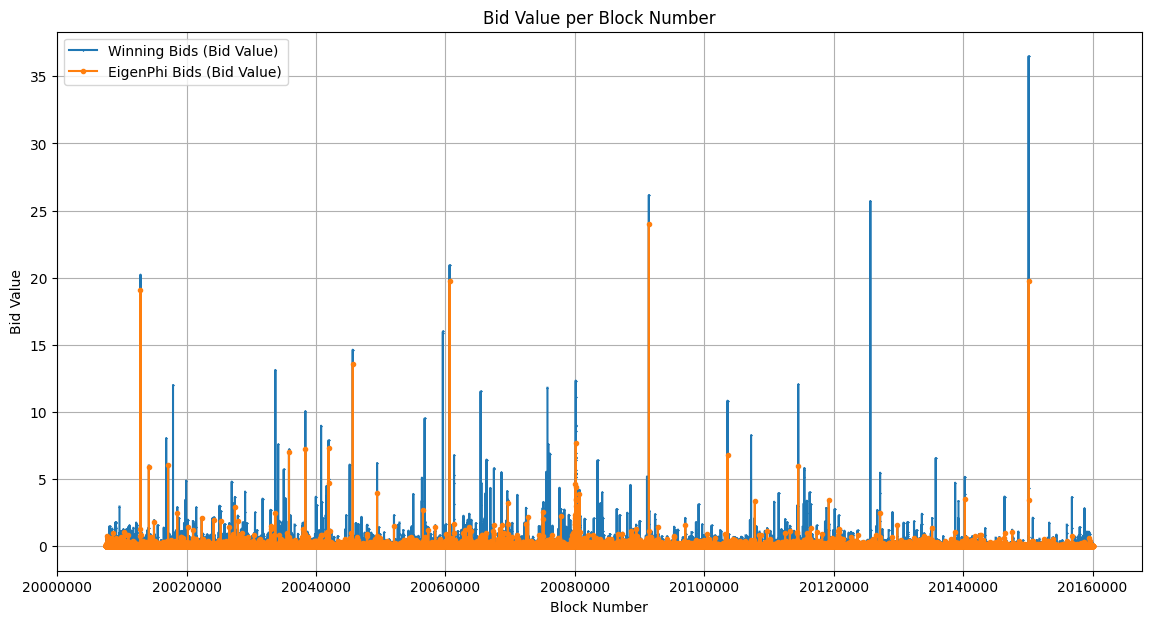

In [22]:

# 绘制线图：bid value per block number
plt.figure(figsize=(14, 7))

# 绘制 df_filtered 的线图
plt.plot(df_filtered['block_number'], df_filtered['value_in_eth'], label='Winning Bids (Bid Value)', marker='x', markersize=1)

# 绘制 df_value_max 的线图
plt.plot(df_value_max['block_number'], df_value_max['value_in_eth'], label='EigenPhi Bids (Bid Value)', marker='o', markersize=3)

# 添加标题和标签
plt.title('Bid Value per Block Number')
plt.xlabel('Block Number')
plt.ylabel('Bid Value')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# 显示图表
plt.show()


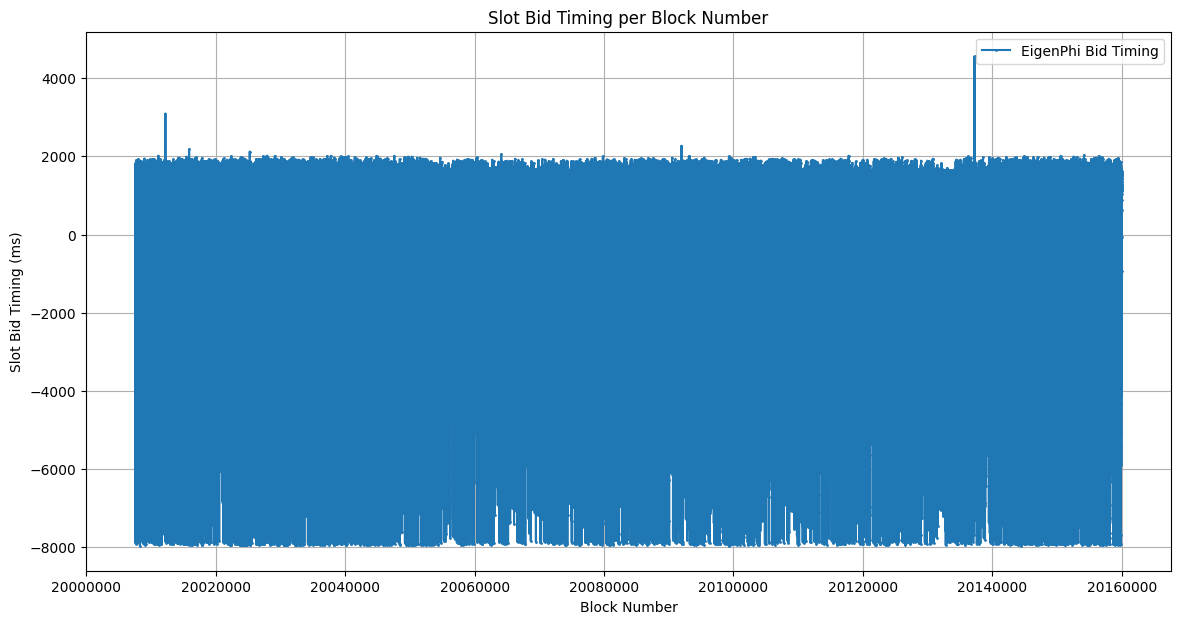

In [26]:


# 绘制线图并调整标记大小 Slot time per block number
plt.figure(figsize=(14, 7))

# 绘制 df_value_max 的线图 (使用 slot_t_ms 作为 y 轴)
plt.plot(df_value_max['block_number'], df_value_max['slot_t_ms'], label='EigenPhi Bid Timing', marker='o', markersize=1)

# # 绘制 df_filtered 的线图 (使用 slot_time_ms 作为 y 轴)
# plt.plot(df_filtered['block_number'], df_filtered['slot_t_ms_adjusted'], label='Winning Bid Timing', marker='x', markersize=1)

# 添加标题和标签
plt.title('Slot Bid Timing per Block Number')
plt.xlabel('Block Number')
plt.ylabel('Slot Bid Timing (ms)')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))


# 显示图表
plt.show()


In [ ]:
# # 检验指定日期和block number的数据
# import requests
# from bs4 import BeautifulSoup
# import zipfile
# import io
# import pandas as pd
# import re
# from data_prep_utils import *
# from plot_prep_utils import *

# pd.set_option('display.float_format', lambda x: '%.2f' % x)

# df_builder = get_builder_info_from_latest_TLDR_talk()
# all_data = pd.read_csv('2024-06-24_all.csv')
# print(all_data["block_number"].min())

# df_1599 = all_data[all_data['block_number'] == 20159999]
# print(df_1599.shape[0])

# df_titan_builder = df_builder[df_builder['builder_label'] == 'Titan']

# df_titan_bids = df_1599[df_1599['builder_pubkey'].isin(df_titan_builder['builder_pubkey'])]

# print(df_1599.columns)

# plt.figure(figsize=(14, 7))

# # 绘制 df_value_max 的线图 (使用 slot_t_ms 作为 y 轴)
# plt.plot(df_titan_bids.index, df_titan_bids['slot_t_ms'], label=' Bids timing (slot_t_ms)', marker='o', markersize=1)

# # # 绘制 df_filtered 的线图 (使用 slot_time_ms 作为 y 轴)
# # plt.plot(df_filtered['block_number'], df_filtered['slot_time_ms'], label='Winning Bids (slot_time_ms)', marker='x', markersize=1)

# # 添加标题和标签
# plt.title('Bid Timings per Block Number')
# plt.xlabel('Block Number')
# plt.ylabel('Bid Timings (ms)')
# plt.legend()
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))


# # 显示图表
# plt.show()

In [25]:
print(all_data.shape[0])

df_builder = get_builder_info_from_latest_TLDR_talk()
print(df_builder["builder_label"].unique())

df_merged = pd.merge(all_data, df_builder, on='builder_pubkey', how='left')
print(df_merged.shape[0])

90464644
['BTCS' 'Beelder' 'Blocknative' 'BuildAI' 'Builder Boi'
 'Building Blocks, Breaking Chains' 'Buildooooooooooooooooooooooor'
 'EigenPhi' 'Gambit Labs' 'I can haz block?'
 'If you build it, they will come.' "It's Free Real Estate" 'Manifold'
 'Titan' 'Ty For The Block' 'antbuilder' 'ashpool' 'beaverbuild'
 'bloXroute' 'bobTheBuilder' 'boba-builder' 'builder0x69' 'default key'
 'eden' 'eth-builder' 'f1b' 'finest artisanal blocks' 'flashbots'
 'ibuilder' 'imposter' 'jetbldr' 'lightspeedbuilder' 'lokibuilder'
 'manta-builder' 'mars' 'merkle Block' 'miao' 'nfactorial' 'panda'
 'payload' 'penguin' 'red ocean surfer' 'rsync' 's0e2t' 'smithbot'
 'smithbuilder' 'spiderbuilder' 'tbuilder' 'uwu.builders' 'wenmerge']
90464644


['beaverbuild' 'rsync' 'Titan' 'bloXroute']
Block count for each builder:
builder_label
Titan          42054
beaverbuild    42148
bloXroute      37395
rsync          41600
Name: block_number, dtype: int64


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/2425863643.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_diff = df_merged.groupby(['block_number', 'relay']).apply(second_highest_bids).reset_index()


Block count for each builder and relay:
builder_label  relay                           
Titan          aestus.live                          3664
               agnostic-relay.net                  31957
               bloxroute.max-profit.blxrbdn.com    32918
               bloxroute.regulated.blxrbdn.com     24743
               boost-relay.flashbots.net           10167
               relay.ultrasound.money              34749
               titanrelay.xyz                       8020
beaverbuild    aestus.live                          7075
               agnostic-relay.net                  31736
               bloxroute.max-profit.blxrbdn.com    28028
               bloxroute.regulated.blxrbdn.com     17366
               boost-relay.flashbots.net           37680
               relay.ultrasound.money              34722
bloXroute      aestus.live                           550
               agnostic-relay.net                   1303
               bloxroute.max-profit.blxrbdn.com    33515


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/2425863643.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)


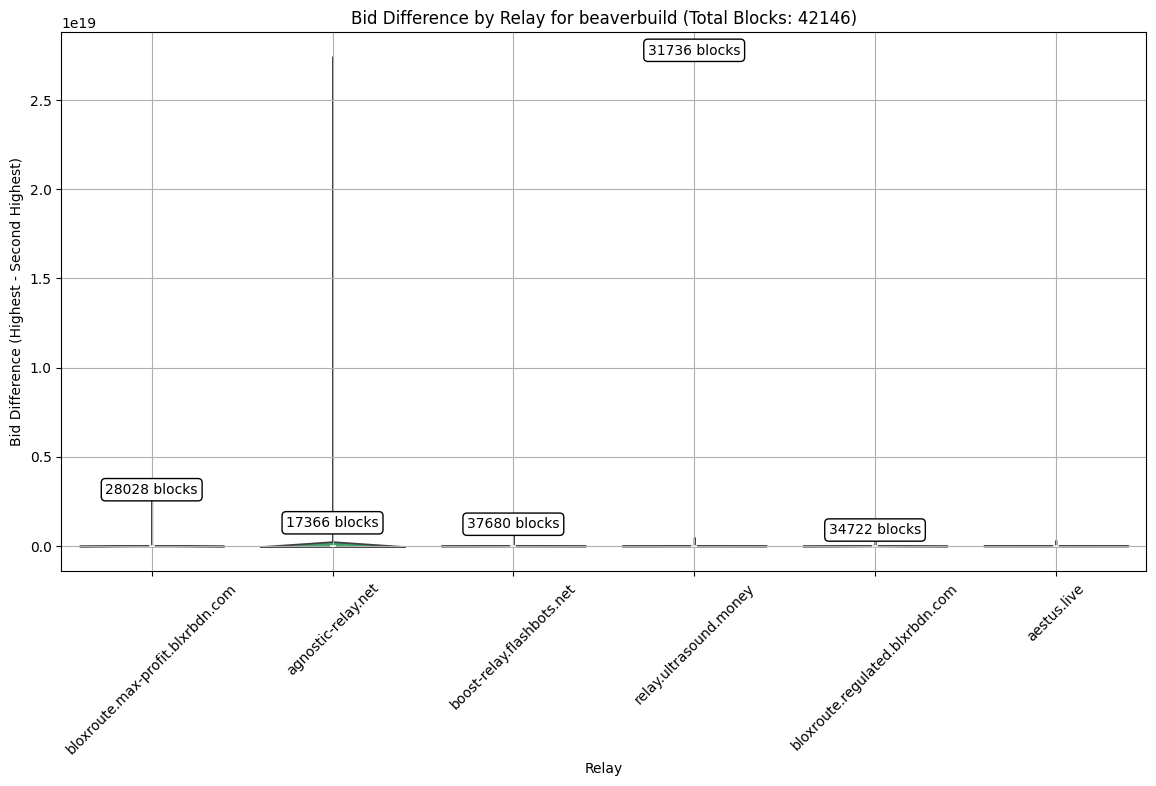

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/2425863643.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)


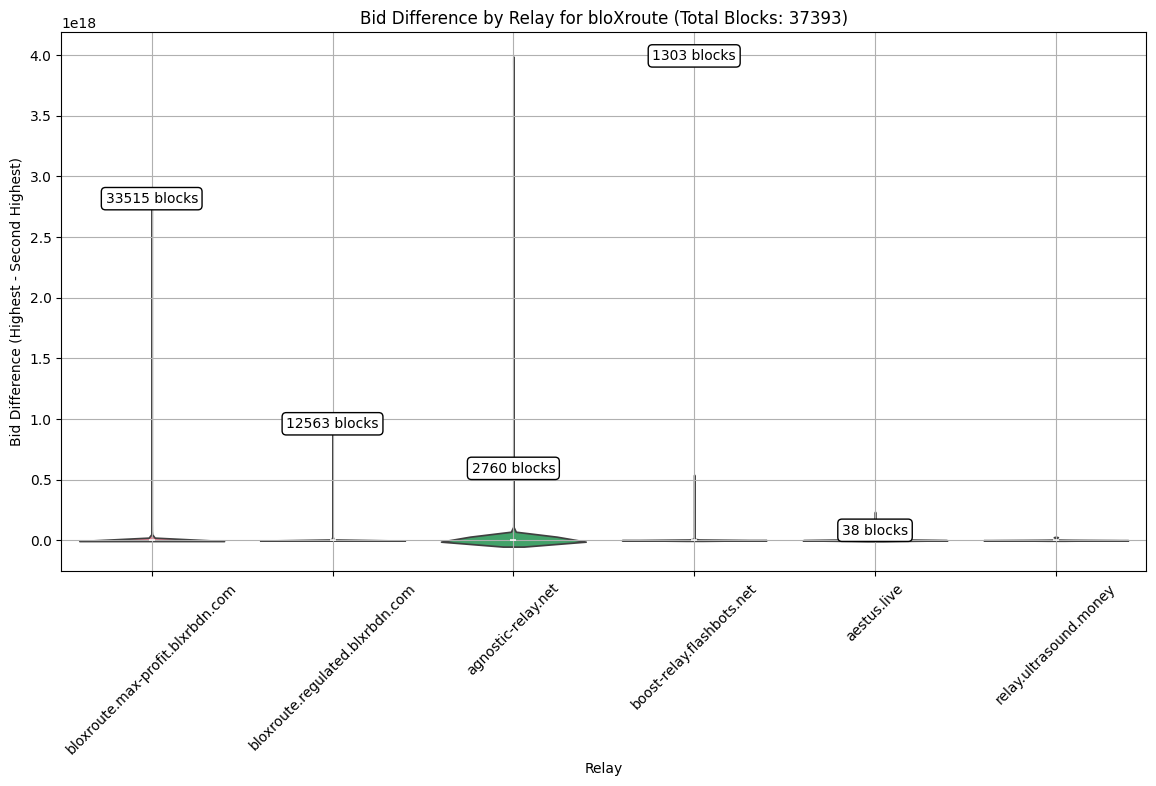

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/2425863643.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)


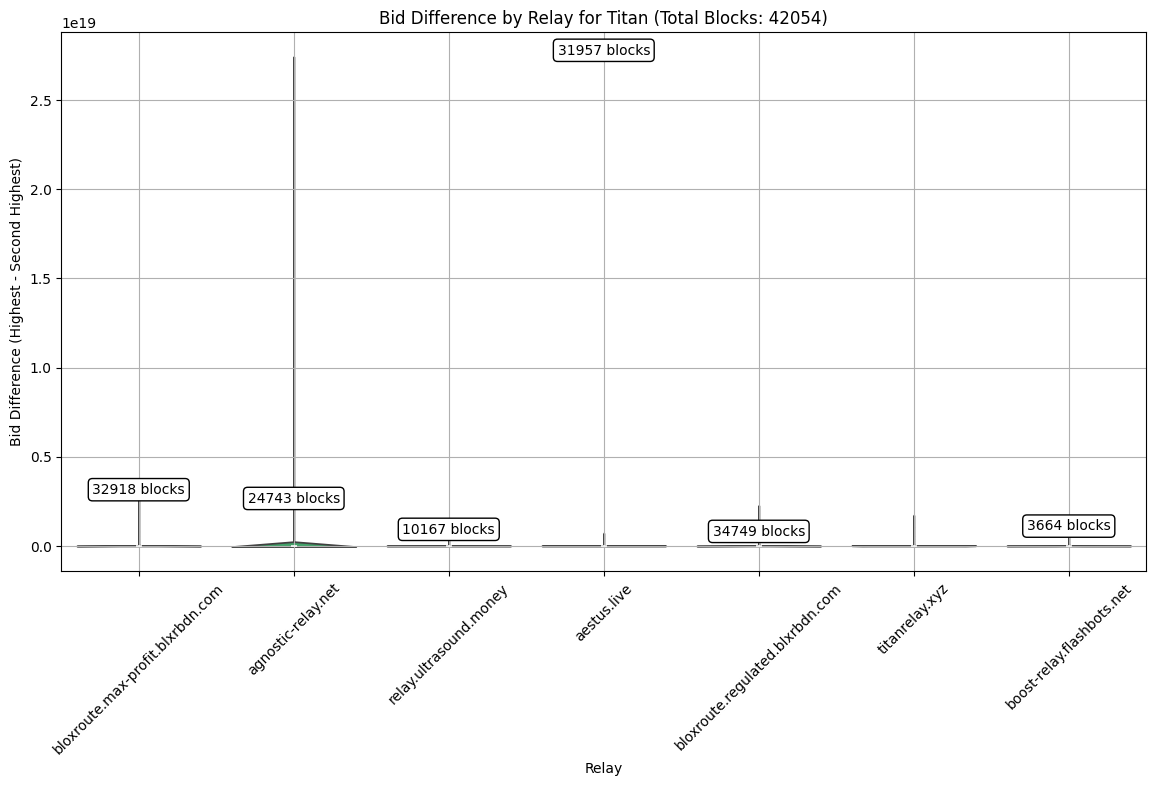

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/2425863643.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)


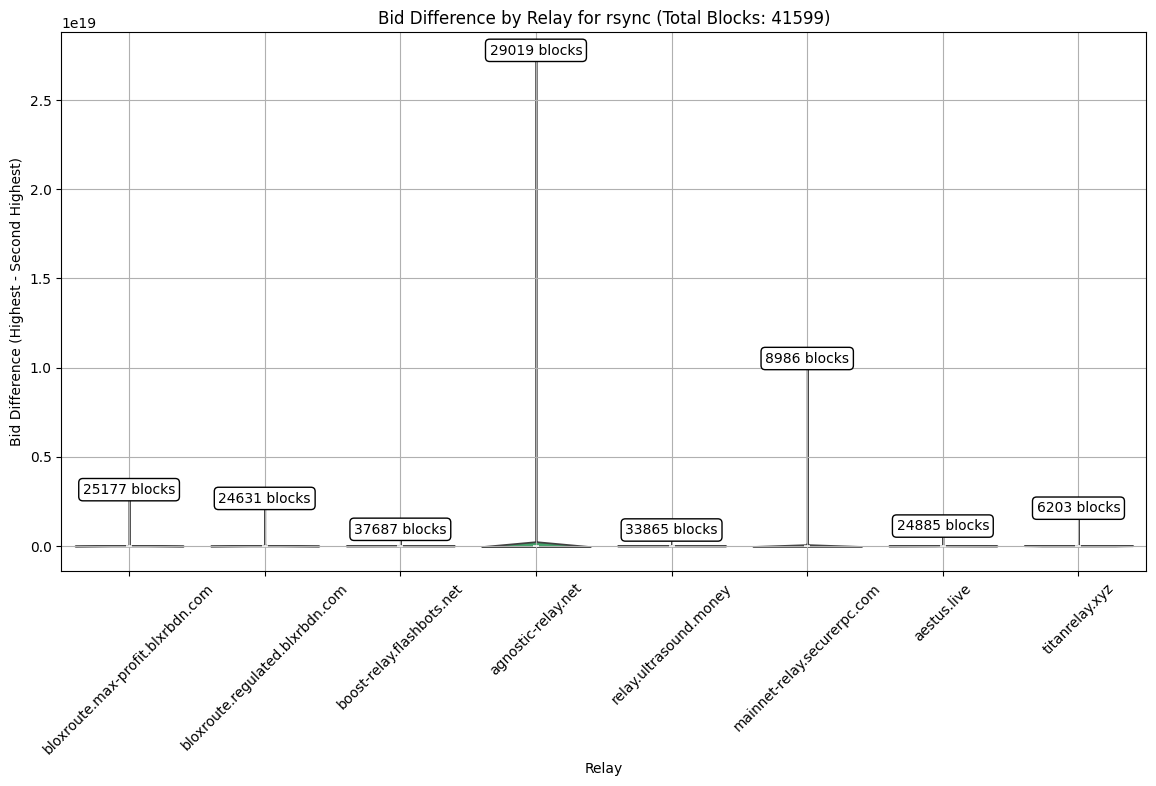

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 df_merged 已经存在并加载了数据

# 过滤特定的 builder_label
df_merged = df_merged[df_merged['builder_label'].isin(['beaverbuild', 'Titan', 'rsync', 'flashbots', 'bloXroute', 'Blocknative'])]
print(df_merged['builder_label'].unique())


# 确保 value 列为数值类型
df_merged['value'] = pd.to_numeric(df_merged['value'], errors='coerce')


builder_block_count = df_merged.groupby('builder_label')['block_number'].nunique()
print("Block count for each builder:")
print(builder_block_count)


# 计算每个 block_number 中的最高和第二高 bid 的差值
def second_highest_bids(df):
    if len(df) < 2:
        return None
    sorted_bids = df['value'].sort_values(ascending=False)
    return sorted_bids.iloc[0] - sorted_bids.iloc[1]

# 计算差值并创建新的 DataFrame
df_diff = df_merged.groupby(['block_number', 'relay']).apply(second_highest_bids).reset_index()
df_diff.columns = ['block_number', 'relay', 'bid_diff']
df_diff = df_diff.dropna()  # 去除没有第二高bid的行

# 合并差值数据框和builder_label
df_diff = pd.merge(df_diff, df_merged[['block_number', 'relay', 'builder_label']].drop_duplicates(), on=['block_number', 'relay'], how='left')

# 获取唯一的builder_label
unique_builders = df_diff['builder_label'].unique()

# 获取唯一的relay并生成颜色映射
unique_relays = df_diff['relay'].unique()
colors = sns.color_palette('husl', len(unique_relays))
relay_color_map = dict(zip(unique_relays, colors))


# 计算每个 builder 在每个 relay 上构建的块数量
builder_relay_block_count = df_diff.groupby(['builder_label', 'relay'])['block_number'].nunique()
print("Block count for each builder and relay:")
print(builder_relay_block_count)

for builder in unique_builders:
    builder_df = df_diff[df_diff['builder_label'] == builder]
    block_count = builder_df['block_number'].nunique()
    
    plt.figure(figsize=(14, 7))
    ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)
    
    for i, relay in enumerate(unique_relays):
        relay_count = builder_relay_block_count.get((builder, relay), 0)
        max_bid_diff = builder_df[builder_df['relay'] == relay]['bid_diff'].max()
        ax.annotate(f'{relay_count} blocks', xy=(i, max_bid_diff), xycoords='data', ha='center', va='bottom', 
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    title = f'Bid Difference by Relay for {builder} (Total Blocks: {block_count})'
    
    plt.title(title)
    plt.xlabel('Relay')
    plt.ylabel('Bid Difference (Highest - Second Highest)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
# # 绘制每个 builder 的小提琴图
# for builder in unique_builders:
#     builder_df = df_diff[df_diff['builder_label'] == builder]
#     block_count = builder_df['block_number'].nunique()
    
#     plt.figure(figsize=(14, 7))
#     ax = sns.violinplot(x='relay', y='bid_diff', data=builder_df, palette=relay_color_map)
    
#     # 在每个violin上添加当前builder在该relay上构建的block数目
#     for i, relay in enumerate(unique_relays):
#         relay_count = builder_relay_block_count.get((builder, relay), 0)
#         # 获取当前violin的最大值
#         max_bid_diff = builder_df[builder_df['relay'] == relay]['bid_diff'].max()
#         # 在violin顶部添加注释
#         ax.annotate(f'{relay_count} blocks', xy=(i, max_bid_diff), xycoords='data', ha='center', va='bottom', 
#                     bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

#     # 设置标题
#     title = f'Bid Difference by Relay for {builder} (Total Blocks: {block_count})'
    
#     plt.title(title)
#     plt.xlabel('Relay')
#     plt.ylabel('Bid Difference (Highest - Second Highest)')
#     plt.xticks(rotation=45)  # 旋转横轴标签
#     plt.grid(True)
#     plt.show()


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_56054/1606951582.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_diff = df_selected_builder_bids.groupby(['block_number', 'relay']).apply(second_highest_bids).reset_index()


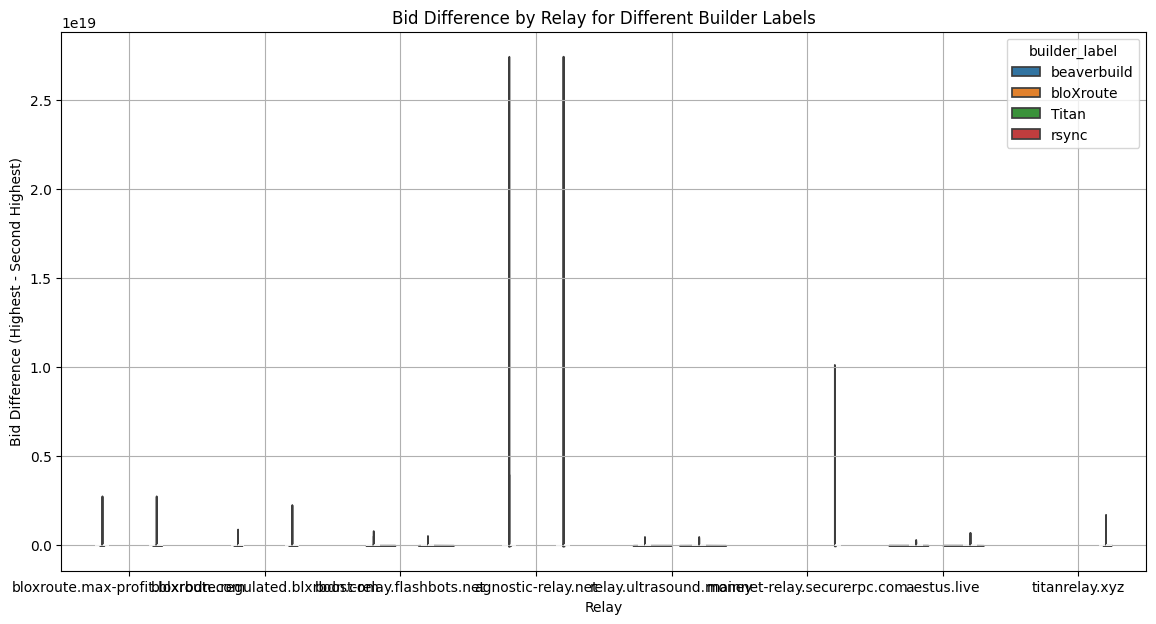

In [16]:
import seaborn as sns


df_merged = df_merged[df_merged['builder_label'].isin(['beaverbuild', 'Titan', 'rsync', 'flashbots', 'bloXroute', 'Blocknative'])]

df_selected_builder_bids = df_merged
df_selected_builder_bids['value'] = pd.to_numeric(df_selected_builder_bids['value'], errors='coerce')


def second_highest_bids(df):
    if len(df) < 2:
        return None
    sorted_bids = df['value'].sort_values(ascending=False)
    return sorted_bids.iloc[0] - sorted_bids.iloc[1]

df_diff = df_selected_builder_bids.groupby(['block_number', 'relay']).apply(second_highest_bids).reset_index()
df_diff.columns = ['block_number', 'relay', 'bid_diff']
df_diff = df_diff.dropna()  # 去除没有第二高bid的行

df_diff = pd.merge(df_diff, df_selected_builder_bids[['block_number', 'relay', 'builder_label']].drop_duplicates(), on=['block_number', 'relay'], how='left')

plt.figure(figsize=(14, 7))
sns.violinplot(x='relay', y='bid_diff', hue='builder_label', data=df_diff, split=True)
plt.title('Bid Difference by Relay for Different Builder Labels')
plt.xlabel('Relay')
plt.ylabel('Bid Difference (Highest - Second Highest)')
plt.grid(True)

plt.show()
